I am going to share predictions about the virus on the basis of time series data known by the scientific name of SARS-CoV-2

SARS-CoV-2 causes the disease COVID-19 (CoV-19) which is an infectious disease declared as a global pandemic by the World Health Organization (WHO) and causes a severe acute respiratory syndrome.

previously known by the provisional name 2019 novel coronavirus (2019-nCoV) this virus is a positive-sense single-stranded RNA virus.

It is contagious in humans and is the cause of the ongoing 2019–20 coronavirus outbreak, an pandemic of coronavirus disease 2019 (COVID-19)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline 

In [3]:
confirmed_df = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
deaths_df = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')
recoveries_df = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv')

In [4]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [5]:
columns = confirmed_df.keys()

In [6]:
confirmed = confirmed_df.loc[:, columns[4]:columns[-1]]
deaths = deaths_df.loc[:, columns[4]:columns[-1]]
recoveries = recoveries_df.loc[:, columns[4]:columns[-1]]

In [7]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)

In [8]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

**Predicting the future**

In [9]:
days_in_future = 15
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]

Convert integer into datetime

In [10]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [11]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.15, shuffle=False) 

Model for predicting number of confirmed cases by using support vector machine,linear regression and ridge regression.

In [12]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   31.5s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [13]:
svm_search.best_params_

{'shrinking': False, 'kernel': 'poly', 'gamma': 0.01, 'epsilon': 1, 'C': 10}

In [14]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 17238.106720993248
MSE: 311347361.9671531


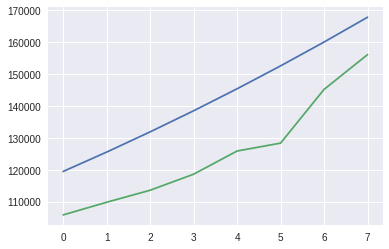

In [15]:
# checking against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [16]:
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 8753.452020202018
MSE: 169179593.56311837


In [17]:
print(linear_model.coef_)
print(linear_model.intercept_)

[[2554.46969697]]
[-5605.11111111]


In [18]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [19]:
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 1e-06,
 'lambda_1': 1e-07,
 'alpha_2': 1e-07,
 'alpha_1': 0.0001}

In [20]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 8771.620510313878
MSE: 170087474.85357457


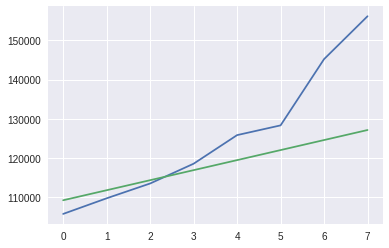

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)

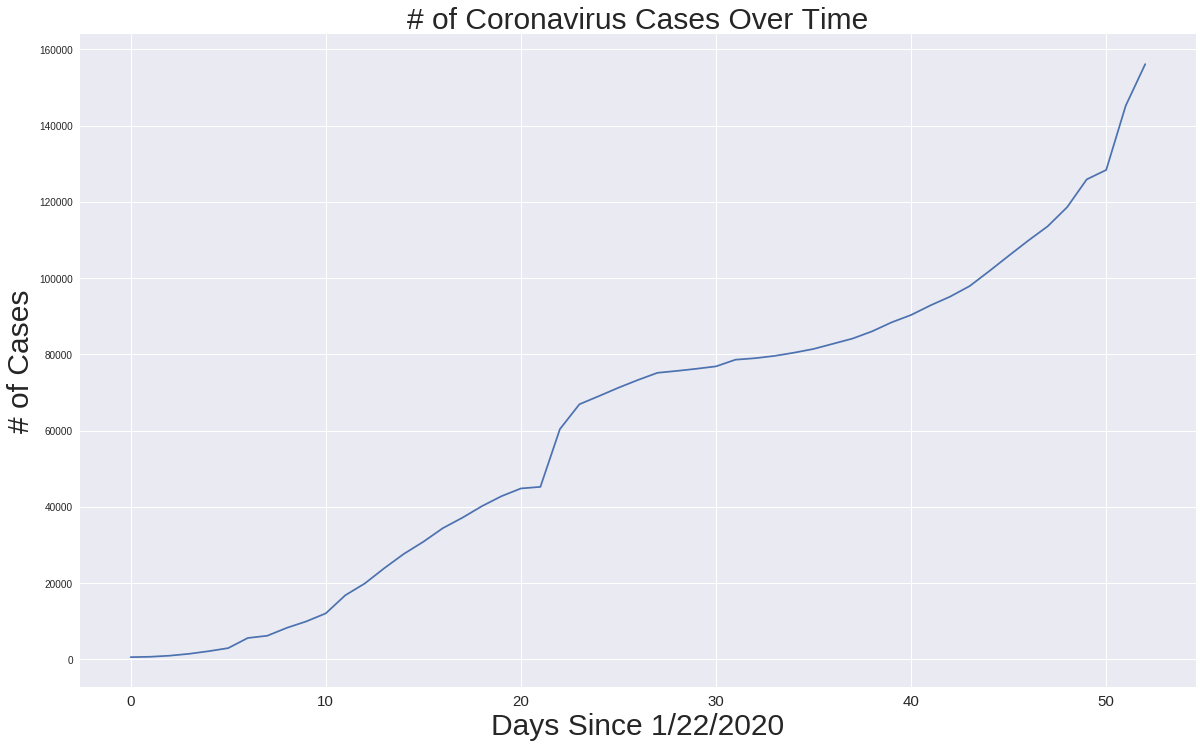

In [22]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=15)
plt.show()

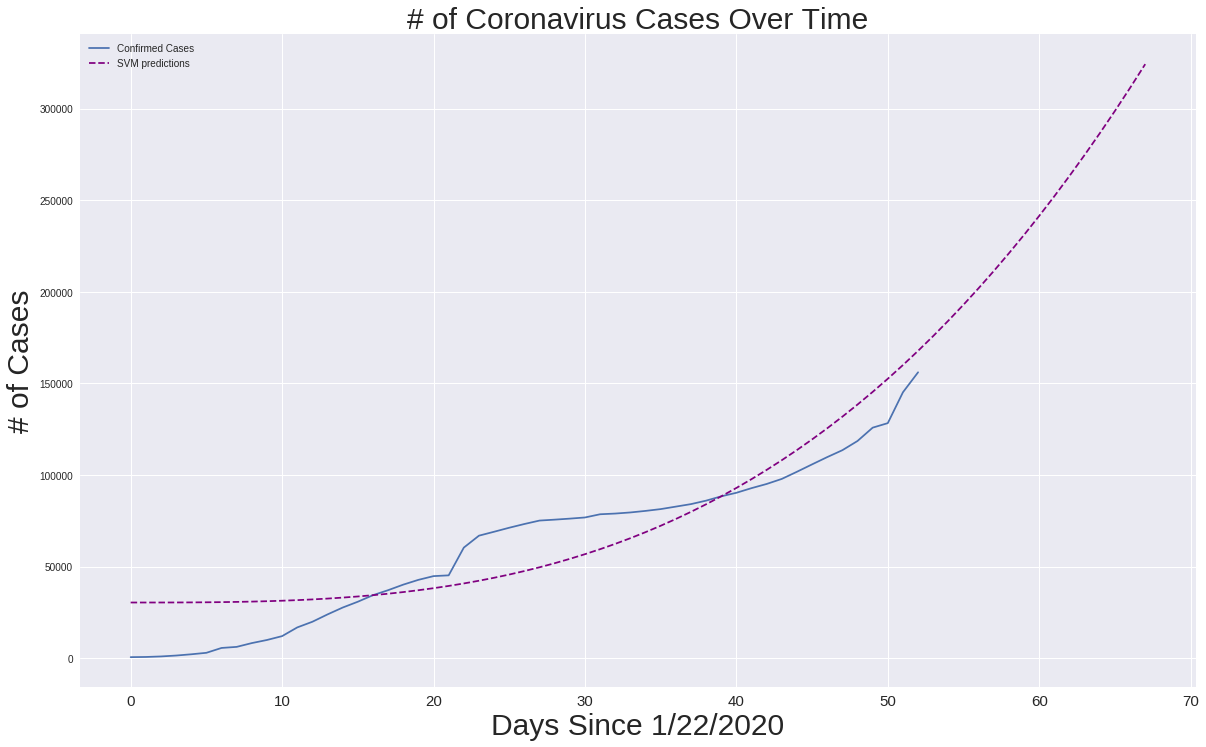

In [23]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'])
plt.xticks(size=15)
plt.show()

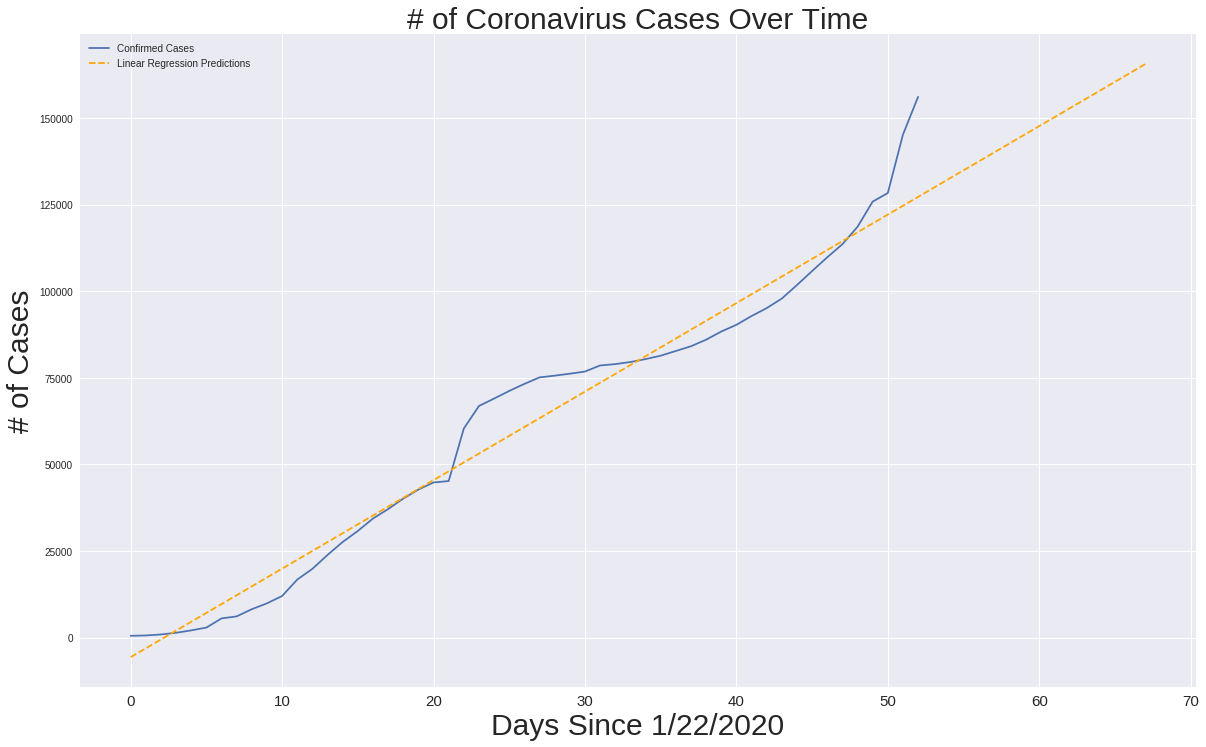

In [24]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Predictions'])
plt.xticks(size=15)
plt.show()

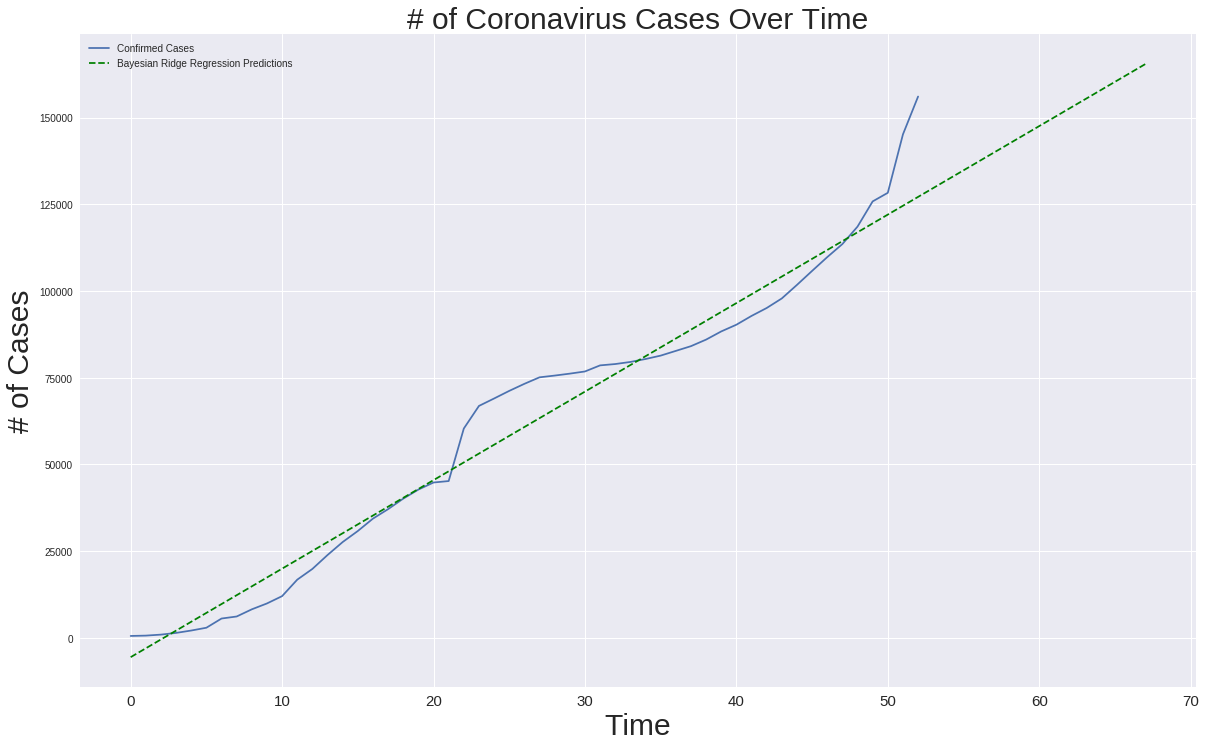

In [25]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Bayesian Ridge Regression Predictions'])
plt.xticks(size=15)
plt.show()

Furure Predictions

In [26]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-15:], svm_pred[-15:]))

SVM future predictions:


{('03/15/2020', 175908.92604843795),
 ('03/16/2020', 184302.3329238902),
 ('03/17/2020', 193012.43524916755),
 ('03/18/2020', 202045.0977548219),
 ('03/19/2020', 211406.18517140602),
 ('03/20/2020', 221101.56222947178),
 ('03/21/2020', 231137.09365957195),
 ('03/22/2020', 241518.64419225854),
 ('03/23/2020', 252252.0785580839),
 ('03/24/2020', 263343.2614876004),
 ('03/25/2020', 274798.0577113601),
 ('03/26/2020', 286622.33195991593),
 ('03/27/2020', 298821.9489638195),
 ('03/28/2020', 311402.7734536233),
 ('03/29/2020', 324370.6701598799)}

In [27]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-15:], bayesian_pred[-15:]))

Ridge regression future predictions:


{('03/15/2020', 129715.52127611017),
 ('03/16/2020', 132267.85350365494),
 ('03/17/2020', 134820.18573119972),
 ('03/18/2020', 137372.5179587445),
 ('03/19/2020', 139924.85018628926),
 ('03/20/2020', 142477.18241383403),
 ('03/21/2020', 145029.5146413788),
 ('03/22/2020', 147581.84686892357),
 ('03/23/2020', 150134.17909646835),
 ('03/24/2020', 152686.51132401312),
 ('03/25/2020', 155238.8435515579),
 ('03/26/2020', 157791.17577910266),
 ('03/27/2020', 160343.50800664743),
 ('03/28/2020', 162895.8402341922),
 ('03/29/2020', 165448.17246173698)}

In [28]:
# Future predictions using Linear Regression 
print('Linear regression future predictions:')
print(linear_pred[-15:])

Linear regression future predictions:
[[129781.78282828]
 [132336.25252525]
 [134890.72222222]
 [137445.19191919]
 [139999.66161616]
 [142554.13131313]
 [145108.6010101 ]
 [147663.07070707]
 [150217.54040404]
 [152772.01010101]
 [155326.47979798]
 [157880.94949495]
 [160435.41919192]
 [162989.88888889]
 [165544.35858586]]


**Number of death prediction:**

SVM Model

In [29]:
# Split data for model
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, total_deaths, test_size=0.15, shuffle=False) 

In [30]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, return_train_score=True, n_iter=40, verbose=1)
svm_search.fit(X_train_deaths, y_train_deaths)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [31]:
print('Best Params are: ')
svm_search.best_params_

Best Params are: 


{'shrinking': False, 'kernel': 'poly', 'gamma': 0.01, 'epsilon': 0.1, 'C': 0.1}

In [32]:
svm_deaths = svm_search.best_estimator_
svm_pred_death = svm_deaths.predict(future_forcast)

MAE: 304.37718723946705
MSE: 113780.46033595514


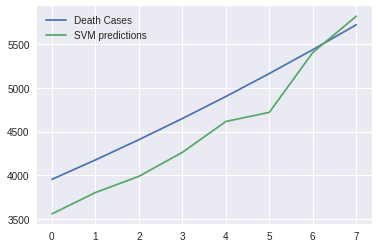

In [33]:
# check against testing data
svm_test_pred = svm_deaths.predict(X_test_deaths)
plt.plot(svm_test_pred)
plt.plot(y_test_deaths)
plt.legend(['Death Cases', 'SVM predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_deaths))
print('MSE:',mean_squared_error(svm_test_pred, y_test_deaths))

Linear regression model

In [34]:
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_deaths, y_train_deaths)
test_linear_pred = linear_model.predict(X_test_deaths)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_deaths))
print('MSE:',mean_squared_error(test_linear_pred, y_test_deaths))

MAE: 693.9388449714529
MSE: 770141.1892710294


In [35]:
print(linear_model.coef_)
print(linear_model.intercept_)

[[88.15744401]]
[-448.57487923]


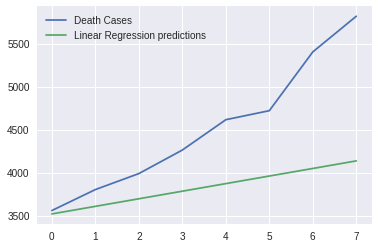

In [36]:
plt.plot(y_test_deaths)
plt.plot(test_linear_pred)
plt.legend(['Death Cases', 'Linear Regression predictions'])

Bayesian ridge regression model 

In [37]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_deaths, y_train_deaths)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [38]:
bayesian_search.best_params_

{'tol': 0.0001,
 'lambda_2': 0.0001,
 'lambda_1': 1e-07,
 'alpha_2': 1e-06,
 'alpha_1': 0.0001}

In [39]:
bayesian_deaths = bayesian_search.best_estimator_
test_bayesian_pred_deaths = bayesian_deaths.predict(X_test_deaths)
bayesian_pred_deaths = bayesian_deaths.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred_deaths, y_test_deaths))
print('MSE:',mean_squared_error(test_bayesian_pred_deaths, y_test_deaths))

MAE: 695.1262799384722
MSE: 771896.9376883423


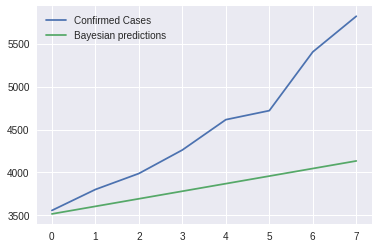

In [40]:
plt.plot(y_test_deaths)
plt.plot(test_bayesian_pred_deaths)
plt.legend(['Confirmed Cases', 'Bayesian predictions'])

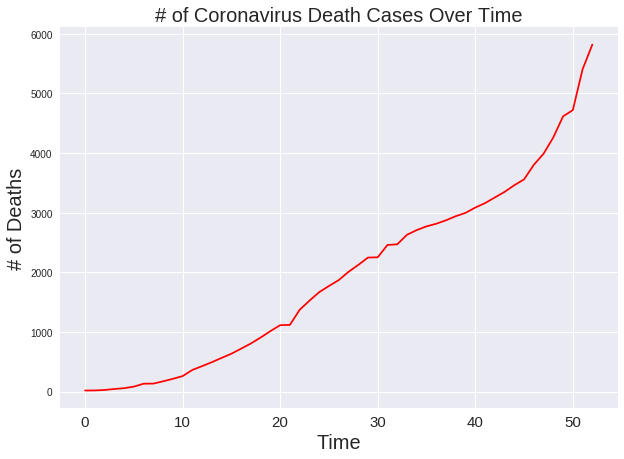

In [41]:
plt.figure(figsize=(10, 7))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Death Cases Over Time', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('# of Deaths', size=20)
plt.xticks(size=15)
plt.show()

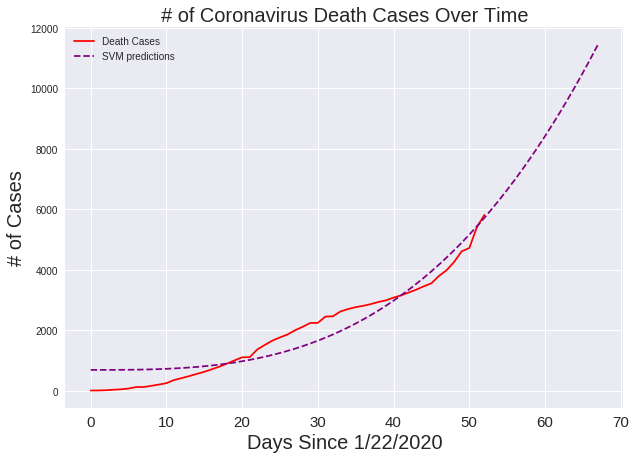

In [42]:
plt.figure(figsize=(10, 7))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(future_forcast, svm_pred_death, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Death Cases Over Time', size=20)
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.legend(['Death Cases', 'SVM predictions'])
plt.xticks(size=15)
plt.show()

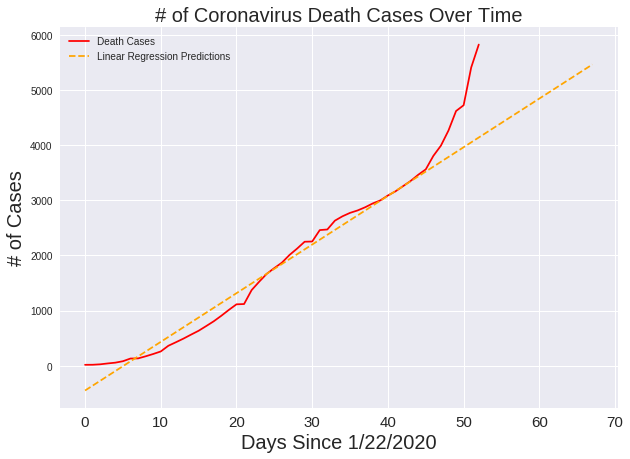

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Death Cases Over Time', size=20)
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.legend(['Death Cases', 'Linear Regression Predictions'])
plt.xticks(size=15)
plt.show()

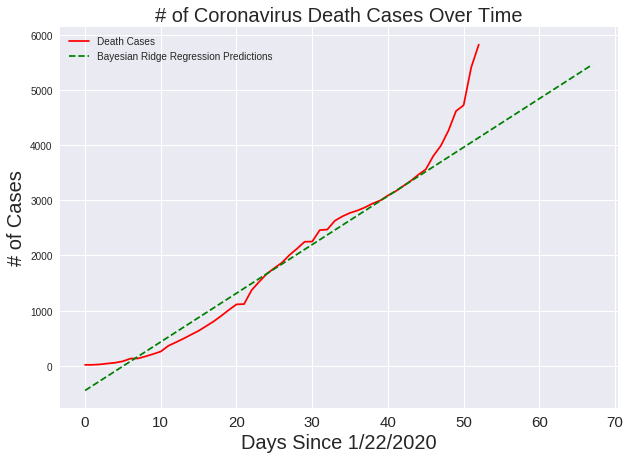

In [44]:
plt.figure(figsize=(10, 7))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(future_forcast, bayesian_pred_deaths, linestyle='dashed', color='green')
plt.title('# of Coronavirus Death Cases Over Time', size=20)
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.legend(['Death Cases', 'Bayesian Ridge Regression Predictions'])
plt.xticks(size=15)
plt.show()

In [45]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-14:], svm_pred_death[-14:]))

SVM future predictions:


{('03/16/2020', 6323.5029478476845),
 ('03/17/2020', 6641.868975937685),
 ('03/18/2020', 6972.02501516781),
 ('03/19/2020', 7314.185429376984),
 ('03/20/2020', 7668.564582404109),
 ('03/21/2020', 8035.376838088095),
 ('03/22/2020', 8414.836560267859),
 ('03/23/2020', 8807.158112782316),
 ('03/24/2020', 9212.555859470365),
 ('03/25/2020', 9631.244164170927),
 ('03/26/2020', 10063.437390722913),
 ('03/27/2020', 10509.349902965223),
 ('03/28/2020', 10969.196064736789),
 ('03/29/2020', 11443.190239876496)}

In [46]:
# Future predictions using Bayesian regression
print('Bayesian regression future predictions:')
set(zip(future_forcast_dates[-14:], bayesian_pred_deaths[-14:]))

Bayesian regression future predictions:


{('03/16/2020', 4310.493213323774),
 ('03/17/2020', 4398.6058484623645),
 ('03/18/2020', 4486.718483600955),
 ('03/19/2020', 4574.831118739545),
 ('03/20/2020', 4662.943753878135),
 ('03/21/2020', 4751.056389016725),
 ('03/22/2020', 4839.169024155315),
 ('03/23/2020', 4927.281659293905),
 ('03/24/2020', 5015.394294432495),
 ('03/25/2020', 5103.5069295710855),
 ('03/26/2020', 5191.619564709676),
 ('03/27/2020', 5279.732199848266),
 ('03/28/2020', 5367.844834986856),
 ('03/29/2020', 5455.957470125446)}

In [47]:
# Future predictions using Linear Regression 
print('Linear regression future predictions:')
print(linear_pred[-14:])

Linear regression future predictions:
[[4311.92709706]
 [4400.08454106]
 [4488.24198507]
 [4576.39942907]
 [4664.55687308]
 [4752.71431708]
 [4840.87176109]
 [4929.02920509]
 [5017.1866491 ]
 [5105.3440931 ]
 [5193.50153711]
 [5281.65898112]
 [5369.81642512]
 [5457.97386913]]


Death and recoveries over time

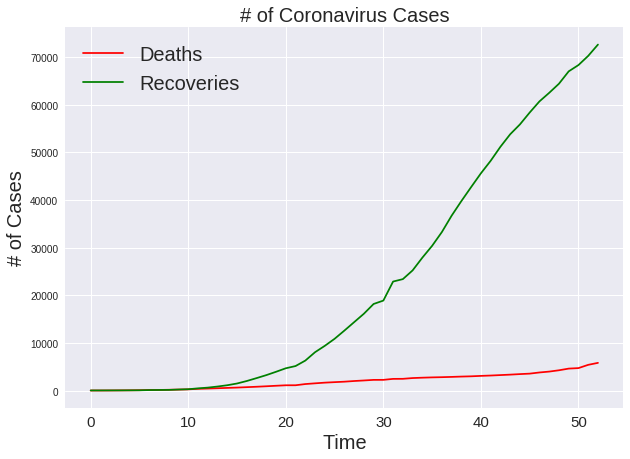

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['Deaths', 'Recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=15)
plt.show()